In [130]:
import nengo
from nengo.utils.matplotlib import rasterplot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nengo_learn_assoc_mem.learning_rules.fake_voja import FakeVoja

In [261]:
class StaticMixed(FakeVoja):

    def __init__(self, encoders: np.ndarray, max_rates: np.ndarray, thresh: float, max_dist=0.2,
                 post_tau=0.005, learning_rate=1e-3, radius=1., sample_every=0.1):
        super().__init__(encoders, post_tau, learning_rate, sample_every)
        self.radius = radius
        self.thresh = thresh
        self.max_dist = max_dist
        self.max_rates = max_rates
        self.ratio_hist = []

    def encode(self, t):
        firing_ratio = self.acts / self.max_rates
        assert np.all(firing_ratio <= 10.)

        lr = self.enabled * self.learning_rate

        dist = self.encoders - self.in_sig
        dist_mag = np.linalg.norm(dist, axis=1)
        dist[dist_mag > self.max_dist] = 0.

        delta = lr * (firing_ratio[:, None] - self.thresh) * dist

        mod_enc = self.encoders + delta
        mag = np.linalg.norm(mod_enc, axis=1)
        self.encoders = self.radius / mag[:, None] * mod_enc

        if (t / self.dt % self.period) < 1:
            self.encoder_hist.append(self.encoders.copy())
            self.ratio_hist.append(firing_ratio.copy())

        return np.dot(self.encoders, self.in_sig)

In [262]:
def cycle_array(x, period, dt=0.001):
    """Cycles through the elements"""
    i_every = int(round(period / dt))
    if i_every != period / dt:
        raise ValueError("dt (%s) does not divide period (%s)" % (dt, period))

    def f(t):
        i = int(round((t - dt) / dt))  # t starts at dt
        return x[int(i / i_every) % len(x)]

    return f

In [263]:
dims = 2
n_neurons = 80
seed = 8
rng = np.random.RandomState(seed)

rad_comp = 1 / np.sqrt(2)

In [264]:
x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T

In [265]:
neg_stim = np.array([-rad_comp, -rad_comp])
pos_stim = np.array([rad_comp, rad_comp])

In [266]:
neg_dist = enc - neg_stim
neg_dist_mag = np.linalg.norm(neg_dist, axis=1)
neg_close_enough = neg_dist_mag > 0.5
neg_dist_mag[neg_close_enough] = 0.

In [267]:
pos_dist = enc - pos_stim
pos_dist_mag = np.linalg.norm(pos_dist, axis=1)
pos_close_enough = pos_dist_mag > 0.5
pos_dist_mag[pos_close_enough] = 0.

(-1.1, 1.1)

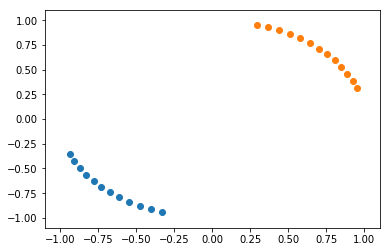

In [268]:
plt.scatter(enc[~neg_close_enough, 0], enc[~neg_close_enough, 1])#,  s=dist_mag*100)
plt.scatter(enc[~pos_close_enough, 0], enc[~pos_close_enough, 1])
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [269]:
fin_enc = enc[(~neg_close_enough | ~pos_close_enough), :]
n_neurons = len(fin_enc)
intercepts = np.ones(n_neurons) * 0.8
max_rates = nengo.dists.Uniform(250, 300).sample(n_neurons, rng=rng)

(-1.1, 1.1)

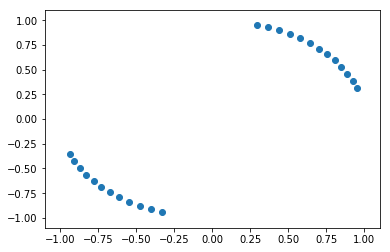

In [270]:
plt.scatter(fin_enc[:, 0], fin_enc[:, 1])
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)

In [279]:
with nengo.Network() as model:
    in_nd = nengo.Node(cycle_array([[-rad_comp, -rad_comp], [rad_comp, rad_comp]], 0.1))
    nvoja_learn_enable = nengo.Node(1)

    neg_voja = StaticMixed(fin_enc.copy(), max_rates,
                           thresh=0.75, learning_rate=-5e-2, max_dist=0.5, sample_every=0.001)
    ens = nengo.Ensemble(n_neurons, 2, intercepts=intercepts, max_rates=max_rates, seed=seed)

    nengo.Connection(in_nd, neg_voja.input_signal, synapse=None)
    nengo.Connection(ens.neurons, neg_voja.input_activities, synapse=0.005)
    nengo.Connection(nvoja_learn_enable, neg_voja.enable, synapse=None)
    nengo.Connection(neg_voja.output, ens.neurons, synapse=None)


    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(model) as sim:
    sim.run(1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

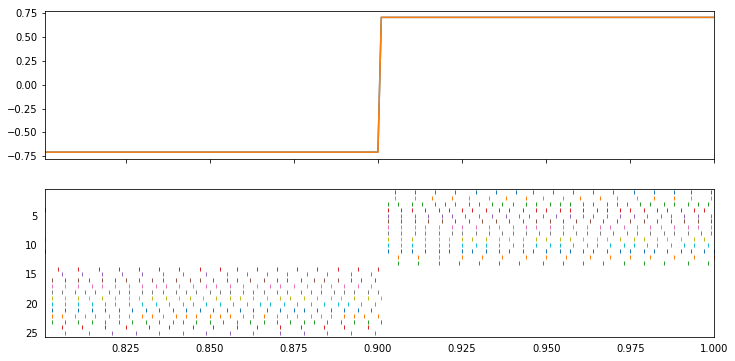

In [280]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax1.plot(sim.trange()[-200:], sim.data[p_in][-200:])
rasterplot(sim.trange()[-200:], sim.data[p_spikes][-200:], ax=ax2)

In [281]:
x_val = np.linspace(0, 2*np.pi, 50)
circ = np.array([np.cos(x_val), np.sin(x_val)]).T

enc_h = neg_voja.encoder_hist
ratio_h = neg_voja.ratio_hist

In [282]:
rh = np.array(ratio_h)

In [283]:
filt_rh = rh[:, np.sum(rh, axis=0) > 450]
filt_rh.shape

(1000, 17)

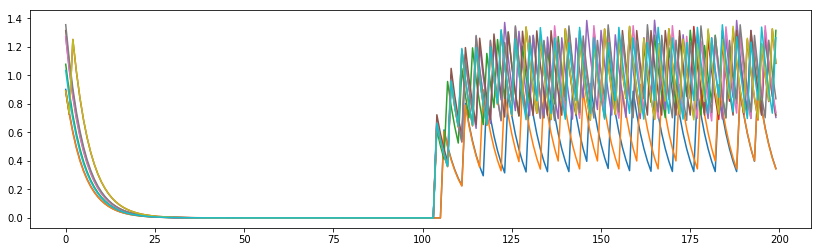

In [284]:
plt.figure(figsize=(14, 4))
plt.plot(rh[-200:, :10])

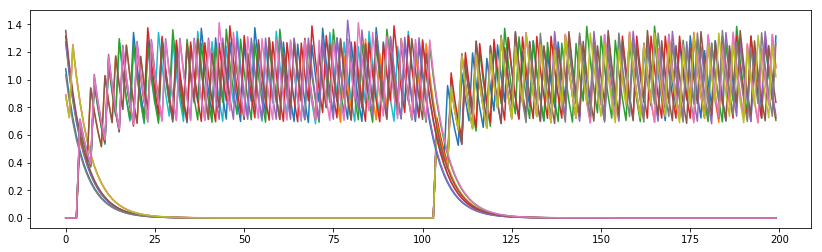

In [285]:
plt.figure(figsize=(14, 4))
plt.plot(filt_rh[-200:])
#plt.xlim(0, 200)

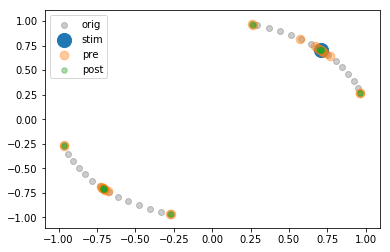

In [286]:
win_pre = 500
win_a = -1

alpha = 0.4

plt.scatter(fin_enc[:, 0], fin_enc[:, 1], color='k', alpha=alpha-0.2, label="orig")
plt.scatter(sim.data[p_in][win_pre][0], sim.data[p_in][win_pre][1], label="stim", s=200)

#plt.scatter(enc_h[0][:, 0], enc_h[0][:, 1], label="first", s=110, alpha=alpha)
plt.scatter(enc_h[win_pre][:, 0], enc_h[win_pre][:, 1], label="pre", s=75, alpha=alpha)
plt.scatter(enc_h[win_a][:, 0], enc_h[win_a][:, 1], label="post", s=30, alpha=alpha)

plt.legend()
# plt.xlim(-1.1, 1.1)
# plt.ylim(-1.1, 1.1)